# Meaningful Census Parameters

- Age by gender
- race w/ hispanic/latino
- total pop
- total housing

- Household type B11001_001E
- sex by age by educational attainment 18+ B15001_001E
- 25+ B15002_001E

- Household income B19001_001E
- Family Income B19101_001E
- Number of Earners in family B19122_001E

- Gini Index B19083_001E

- Occupancy/ Housing B25002_001E
- median number fo rooms B25018_001E
- median year structure built B25035_001E
- contract rent B25057_001E
- value B25076_001E
- voting age details B29002_007E

Isolating to extensive variables:

In [7]:
import itertools
import time

import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tqdm

import sqlite3

%matplotlib inline

In [2]:
import spatialite

with spatialite.connect(':memory:') as db:
    print(db.execute('SELECT spatialite_version()').fetchone()[0])

4.3.0a


In [ ]:
# Code: (display name, long name)
pop_variables = {
    'B01001_001E': ("population", "UNWEIGHTED SAMPLE COUNT OF THE POPULATION"),
    'B01001_002E': ("male", "total male"),
    'B01001_026E': ("female", "total female")
}


sexes = ["male", "female"]
ages = ["under 5", "5-9", "10-14", "15-17", "18-19", "20", "21", "22-24", 
        "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", 
        "60-61", "62-64", "65-66", "67-69", "70-74", "75-79", "80-84", 
        "85 plus"]
display_name = [sex + " " + age for sex in sexes for age in ages]
vals = ["B01001_" + str(i).zfill(3) + "E" for i in range(3, 50) if i != 26]
gender_by_age = {val: (disp, disp) for val, disp in zip(vals, display_name)}

races = ["white", "AA", "AIAN", "asian", "NHOPI", "other", "two+"]
long_names = ["White alone", "Black or African American alone", "American Indian and Alaska Native alone",
             "Asian alone", "Native Hawaiian and Other Pacific Islander alone", "Some other race alone", "Two or more races"]
vals = ["B02001_" + str(i).zfill(3) + "E" for i in range(2,9)]
races = {val: (race, long) for val, race, long in zip(vals, races, long_names)}

ed_attainment = ["none", "up to 4", "5-6", "7-8", "9", "10", "11", "12", "HS", "1C", "some college", "assoc", "bach", "master", "prof", "doc"]
disp_ed_attain = [sex + " " + ed for sex in sexes for ed in ed_attainment]
ed_attainment_long = ["No schooling completed", "Nursery to 4th grade", "5th and 6th grade", "7th and 8th grade",
                     "9th grade", "10th grade", "11th grade", "12th grade, no diploma", "High school graduate (includes equivalency)",
                     "Some college, less than 1 year", "Some college, 1 or more years, no degree", "Associate's degree",
                     "Bachelor's degree", "Master's degree", "Professional school degree", "Doctorate degree"]
disp_ed_attain_long = [sex + " " + ed for sex in sexes for ed in ed_attainment_long]
vals = ["B15002_" + str(val).zfill(3) + "E" for val in range(3,36) if val != 19]
ed_attain = {val: (short, long) for val, short, long in zip(vals, disp_ed_attain, disp_ed_attain_long)}

print(len(pop_variables), len(gender_by_age), len(races), len(ed_attain))

In [3]:
home_variables = {
    'B00002_001E': ("houses", "UNWEIGHTED SAMPLE HOUSING UNITS"),
    'B11001_002E': ("family", "Family households"),
    'B11001_003E': ("married", "Maried couple family"),
    'B11001_004E': ("other family", "Other family"),
    'B11001_007E': ("nonfamily", "Nonfamily household"),
    'B25001_001E': ("houses2", "HOUSING UNITS"),
    'B25002_002E': ("occupied", "occupied"),
    'B25002_003E': ("vacant", "vacant"),
    'B25003_002E': ("owner-occupied", "owner-occupied"),
    'B25003_003E': ("renter-occupied", "renter-occupied"),
}

house_income = ["less 10", "10-15", "15-20", "20-25", "25-30", "35-40", 
                "45-50", "50-60", "60-75", "75-100", "100-125", 
                "125-150", "150-200", "200 or more"]
vals = ["B19001_" + str(val).zfill(3) + "E" for val in range(2, 18)]
house_income = {val: (label, label) for val, label in zip(vals, house_income)}

house_value = ["less 10", "10-15", "15-20", "20-25", "25-30", "30-35", 
               "35-40", "40-45", "45-50", "50-60", "60-70", "70-80", 
               "80-90", "90-100", "100-125", "125-150", "150-175", "175-200",
               "200-250", "250-300", "300-400", "400-500", "500-750",
               "750-1000", "1000-1500", "1500-2000", "more than 2000"]
vals = ["B25075_" + str(val).zfill(3) + "E" for val in range(2, 28)]
house_value = {val: (label, label) for val, label in zip(vals, house_value)}

print(len(home_variables), len(house_income), len(house_value))

10 14 26


In [4]:
variable_groups = [pop_variables, gender_by_age, races, ed_attain, home_variables, house_income, house_value]

# Download

## Get a list of the counties

In [109]:
prec_2018 = gpd.read_file("../data/processed/precincts/precincts_2018.geojson")
county_fips = sorted(list(set(prec_2018.COUNTYFP.values)))

In [110]:
prec_2016 = gpd.read_file("../data/processed/precincts/precincts_2016.geojson")

## Download data for every county

In [54]:
def block_substring(block):
    return "%20".join([key+":"+block[key] for key in block])

def compose_request_str(api_root, variables, for_block, in_block, key):
    request = (api_root + 
               "get=" + ",".join(variables) + 
               "&for=" + block_substring(for_block) + 
               "&in=" + block_substring(in_block) + 
               "&key=" + key )
    return request

def scan_county(api_root, variables, for_block, in_block, api_key):
    data = pd.DataFrame()
    for i, county in tqdm.tqdm(enumerate(county_fips)):
        in_block["county"] = county
        t1 = time.time()
        response = requests.get(
            compose_request_str(api_root, variables, for_block, in_block, api_key)
            )
        t2 = time.time()
        #print(f"{i}/{len(county_fips)}: {county}, {response.status_code}, "
        #      f"{len(response.json())}, dt = {t2-t1:.3F}")
        df = pd.DataFrame(data=response.json()[1:], columns=response.json()[0])
        data = data.append(df)
    return data

In [55]:
api_root = "https://api.census.gov/data/2018/acs/acs5?"
for_block = {"block%20group": "*"}
in_block = {"state": "08",
            "county": "013"}
api_key = "b19b387a819c219d7e4f0569c1ef8c5e3b237ace"

data_2018 = []
for variables in variable_groups:
    data_2018.append(scan_county(api_root, list(variables.keys()), for_block, in_block, api_key))

64it [01:02,  1.03it/s]
64it [01:27,  1.37s/it]
64it [01:15,  1.18s/it]
64it [01:19,  1.25s/it]
64it [01:23,  1.31s/it]
64it [01:11,  1.11s/it]
64it [01:08,  1.07s/it]


In [56]:
api_root = "https://api.census.gov/data/2016/acs/acs5?"

data_2016 = []
for variables in variable_groups:
    data_2016.append(scan_county(api_root, list(variables.keys()), for_block, in_block, api_key))

64it [01:10,  1.11s/it]
64it [01:10,  1.11s/it]
64it [01:05,  1.02s/it]
64it [01:07,  1.05s/it]
64it [01:18,  1.23s/it]
64it [01:07,  1.05s/it]
64it [01:07,  1.06s/it]


In [57]:
api_root = "https://api.census.gov/data/2014/acs/acs5?"

data_2014 = []
for variables in variable_groups:
    data_2014.append(scan_county(api_root, list(variables.keys()), for_block, in_block, api_key))

64it [01:04,  1.01s/it]
64it [01:08,  1.08s/it]
64it [03:10,  2.98s/it]
64it [03:33,  3.33s/it]
64it [03:30,  3.28s/it]
64it [01:04,  1.01s/it]
0it [00:00, ?it/s]


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [58]:
def format_and_save_data(data, variable_groups, year):
    form_data = []
    for i in range(7):
        new_df = (data[i].rename(columns={key: variable_groups[i][key][0] for key in variable_groups[i]})
                            .assign(blockgroup = lambda x: x.state+x.county+x.tract+x['block group'])
                            .set_index('blockgroup', drop=True)
                            .drop(columns=['state', 'county', 'tract', 'block group'])
                            .apply(pd.to_numeric, axis=0))
        form_data.append(new_df)
        new_df.to_csv("../data/raw/census_data/bg_data/bg_data_" + str(i) + "_" + str(year) + ".csv")
    return form_data

In [71]:
form_data_2018 = format_and_save_data(data_2018, variable_groups, 2018)
form_data_2016 = format_and_save_data(data_2016, variable_groups, 2016)
form_data_2014 = format_and_save_data(data_2014, variable_groups, 2014)

IndexError: list index out of range

In [9]:
def load_census_data(year):
    form_data = [(pd.read_csv("../data/raw/census_data/bg_data/bg_data_" + str(i) + "_" + str(year) + ".csv")
                .set_index('blockgroup', drop=True)) for i in range(7)]
    return form_data

# Combine Data and Aggregate

## Sex by Age

Sex by age is currently split into a large number of age categories. I'd like to combine it into: under 18, 18-29, 30-50, 50-65, 65 plus

In [72]:
sex_by_age_df = form_data_2016[1]
sex_by_age_df.head()

,male under 5,male 5-9,male 10-14,male 15-17,male 18-19,male 20,male 21,male 22-24,male 25-29,male 30-34,male 35-39,male 40-44,male 45-49,male 50-54,male 55-59,male 60-61,male 62-64,male 65-66,male 67-69,male 70-74,male 75-79,male 80-84,male 85 plus,female under 5,female 5-9,female 10-14,female 15-17,female 18-19,female 20,female 21,female 22-24,female 25-29,female 30-34,female 35-39,female 40-44,female 45-49,female 50-54,female 55-59,female 60-61,female 62-64,female 65-66,female 67-69,female 70-74,female 75-79,female 80-84,female 85 plus
blockgroup,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
080010078011,63,64,42,71,32,0,51,7,103,65,39,74,66,57,19,0,29,9,9,32,8,0,0,148,85,106,103,44,0,11,71,21,54,60,53,95,62,40,0,28,18,7,25,23,0,0
080010078012,120,102,50,15,17,24,24,13,218,133,215,58,90,68,54,0,28,12,37,0,0,0,0,132,70,166,67,75,41,21,48,42,92,60,38,164,50,28,21,12,9,25,9,32,0,0
080010078021,109,107,31,26,54,35,40,16,16,58,14,82,63,15,30,0,16,0,17,16,0,13,0,41,63,87,35,18,86,13,20,73,54,63,65,56,25,34,0,26,34,12,13,13,6,6
080010078022,16,88,66,16,0,19,0,29,57,11,107,83,37,60,24,0,12,0,0,0,6,0,0,55,73,72,46,29,9,23,20,28,45,41,66,32,14,10,20,12,0,0,6,0,7,0
080010078023,57,19,62,77,24,10,0,33,118,75,41,88,78,28,40,0,0,0,0,0,7,0,0,59,95,137,30,70,0,24,27,138,46,38,92,88,33,0,8,0,0,14,0,0,0,0


In [70]:
sex_by_age_df = form_data_2018[1]
sex_by_age_df.head()

,male under 5,male 5-9,male 10-14,male 15-17,male 18-19,male 20,male 21,male 22-24,male 25-29,male 30-34,male 35-39,male 40-44,male 45-49,male 50-54,male 55-59,male 60-61,male 62-64,male 65-66,male 67-69,male 70-74,male 75-79,male 80-84,male 85 plus,female under 5,female 5-9,female 10-14,female 15-17,female 18-19,female 20,female 21,female 22-24,female 25-29,female 30-34,female 35-39,female 40-44,female 45-49,female 50-54,female 55-59,female 60-61,female 62-64,female 65-66,female 67-69,female 70-74,female 75-79,female 80-84,female 85 plus
blockgroup,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
080010095531,124,78,82,25,14,0,53,64,159,96,82,138,174,148,92,0,8,0,19,54,0,5,19,0,99,124,68,10,15,10,34,96,103,79,88,30,87,88,0,21,0,8,16,67,26,22
080010096061,24,32,7,0,20,0,26,29,94,80,17,77,62,54,0,19,28,0,17,13,5,0,0,47,0,143,79,30,22,45,38,21,39,109,114,93,8,42,0,0,15,5,0,0,6,0
080010096062,67,30,77,14,17,0,7,76,42,28,55,12,18,40,62,0,61,7,20,0,41,0,0,10,22,32,18,35,0,0,0,47,21,38,43,29,81,16,15,18,25,0,6,0,0,37
080010082001,71,113,108,91,6,24,0,37,35,102,86,59,66,21,151,18,10,31,43,35,59,12,11,136,116,136,40,12,19,22,44,83,150,25,82,49,71,95,17,13,11,46,28,50,23,0
080010082003,53,62,45,6,0,10,0,97,78,165,42,134,33,21,48,0,0,0,0,9,0,21,0,44,27,32,22,10,0,21,30,150,47,39,38,27,18,12,26,24,0,0,11,24,12,33


In [126]:
def agregate_with_sex(df, sex_idx, new_cols):
    agg = pd.DataFrame()
    for s, idx in sex_idx:
        for label, start, stop in new_cols:
            agg[s+" "+label] = df.iloc[:,idx+start:idx+stop+1].sum(axis=1)
    return agg

In [129]:
sex_idx = [('male', 0), ('female', 23)]
new_cols = [('under 18', 0, 3), ('18-29', 4, 9), ('30-49', 10, 12), ('50-64', 13, 16), ('over 65', 17, 22)]
sex_by_age_df_agg_2018 = agregate_with_sex(form_data_2018[1], sex_idx, new_cols)
sex_by_age_df_agg_2016 = agregate_with_sex(form_data_2016[1], sex_idx, new_cols)

In [130]:
sex_by_age_df_agg_2018.head()

,male under 18,male 18-29,male 30-49,male 50-64,male 65 plus,female under 18,female 18-29,female 30-49,female 50-64,female 65 plus
blockgroup,,,,,,,,,,
080010095531,309,386,394,248,97,291,268,197,196,139
080010096061,63,249,156,101,35,269,195,316,50,26
080010096062,188,170,85,163,68,82,103,110,130,68
080010082001,383,204,211,200,191,428,330,156,196,158
080010082003,166,350,209,69,30,125,258,104,80,80


In [125]:
sex_by_age_df_agg_2016.head()

,under 18 Male,18-29 Male,30-49 Male,50-64 Male,65 plus Male,under 18 Female,18-29 Female,30-49 Female,50-64 Female,65 plus Female
blockgroup,,,,,,,,,,
080010078011,240,258,179,105,58,442,201,208,130,73
080010078012,287,429,363,150,49,435,319,262,111,75
080010078021,273,219,159,61,46,226,264,184,85,84
080010078022,186,116,227,96,6,246,154,139,56,13
080010078023,215,260,207,68,7,321,305,218,41,14


## Educational Attainment

Target groups: no HS, some HS, HS, some College, Bach, master+prof, doc

In [13]:
ed_attain_df = form_data[3]
ed_attain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3532 entries, 80010095531 to 81259632004
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   male none            3532 non-null   int64
 1   male up to 4         3532 non-null   int64
 2   male 5-6             3532 non-null   int64
 3   male 7-8             3532 non-null   int64
 4   male 9               3532 non-null   int64
 5   male 10              3532 non-null   int64
 6   male 11              3532 non-null   int64
 7   male 12              3532 non-null   int64
 8   male HS              3532 non-null   int64
 9   male 1C              3532 non-null   int64
 10  male some college    3532 non-null   int64
 11  male assoc           3532 non-null   int64
 12  male bach            3532 non-null   int64
 13  male master          3532 non-null   int64
 14  male prof            3532 non-null   int64
 15  male doc             3532 non-null   int64
 16  female 

In [131]:
sex_idx = [('male', 0), ('female', 16)]
new_cols = [('no hs', 0, 3), ('some hs', 4, 7), ('hs diploma', 8, 8),
            ('some college', 9, 11), ('bachelors', 12, 12),
            ('masters', 13, 14), ('doctorate', 15, 15)]
ed_attain_agg_2018 = agregate_with_sex(form_data_2018[3], sex_idx, new_cols)
ed_attain_agg_2016 = agregate_with_sex(form_data_2016[3], sex_idx, new_cols)

In [132]:
ed_attain_agg_2018.head()

,male no hs,male some hs,male hs diploma,male some college,male bachelors,male masters,male doctorate,female no hs,female some hs,female hs diploma,female some college,female bachelors,female masters,female doctorate
blockgroup,,,,,,,,,,,,,,
080010095531,372,141,189,132,106,54,0,173,71,166,205,87,29,0
080010096061,70,137,117,91,22,29,0,83,99,123,109,22,16,0
080010096062,95,59,115,45,60,12,0,17,8,171,111,59,10,0
080010082001,109,70,288,142,82,36,12,52,137,238,211,71,34,0
080010082003,77,100,199,114,46,0,15,21,134,96,162,18,20,10


## Home Income

less than 15, 15-30, 30-60, 60-100, 100-150, more than 150

In [16]:
home_income_df = form_data[5]
home_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3532 entries, 80010095531 to 81259632004
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   less 10      3532 non-null   int64
 1   10-15        3532 non-null   int64
 2   15-20        3532 non-null   int64
 3   20-25        3532 non-null   int64
 4   25-30        3532 non-null   int64
 5   35-40        3532 non-null   int64
 6   45-50        3532 non-null   int64
 7   50-60        3532 non-null   int64
 8   60-75        3532 non-null   int64
 9   75-100       3532 non-null   int64
 10  100-125      3532 non-null   int64
 11  125-150      3532 non-null   int64
 12  150-200      3532 non-null   int64
 13  200 or more  3532 non-null   int64
dtypes: int64(14)
memory usage: 413.9 KB


In [77]:
def aggregate_simple(df, new_cols):
    agg = pd.DataFrame()
    for label, start, stop in new_cols:
        agg[label] = df.iloc[:, start:stop+1].sum(axis=1)
    return agg

In [78]:
new_cols = [('less than 15k', 0, 1), ('15k-30k', 2, 4), ('30k-60k', 5, 7),
            ('60k-100k', 8, 9), ('100k-150k', 10, 11), ('more than 150k', 12, 13)]
home_income_agg_2018 = aggregate_simple(form_data_2018[5], new_cols)
home_income_agg_2016 = aggregate_simple(form_data_2016[5], new_cols)

In [81]:
home_income_agg_2016.head()

,less than 15k,15k-30k,30k-60k,60k-100k,100k-150k,more than 150k
blockgroup,,,,,,
080010078011,136,164,65,90,84,0
080010078012,159,301,117,66,74,9
080010078021,139,107,110,57,60,17
080010078022,48,126,102,52,39,0
080010078023,111,178,78,39,44,24


## Home Value

less than 150, 150-200, 200-250, 250-300, 300-400, 400+

In [19]:
home_value_df = form_data[6]
vals = home_value_df.sum().cumsum()
vals = (vals-vals.min())/(vals.max())
vals

less 10      0.000000
10-15        0.004733
15-20        0.008737
20-25        0.012746
25-30        0.016944
30-35        0.020555
35-40        0.023070
40-45        0.028329
45-50        0.035038
50-60        0.040925
60-70        0.047197
70-80        0.056249
80-90        0.064599
90-100       0.092248
100-125      0.122584
125-150      0.175259
150-175      0.225888
175-200      0.343458
200-250      0.460447
250-300      0.660312
300-400      0.790127
400-500      0.918637
500-750      0.957533
750-1000     0.974466
1000-1500    0.980147
1500-2000    0.987609
dtype: float64

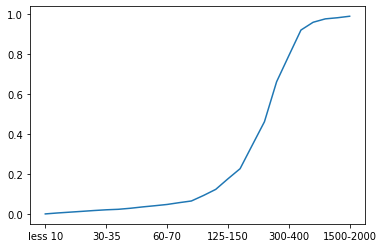

In [20]:
vals.plot()

In [21]:
home_value_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3532 entries, 80010095531 to 81259632004
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   less 10    3532 non-null   int64
 1   10-15      3532 non-null   int64
 2   15-20      3532 non-null   int64
 3   20-25      3532 non-null   int64
 4   25-30      3532 non-null   int64
 5   30-35      3532 non-null   int64
 6   35-40      3532 non-null   int64
 7   40-45      3532 non-null   int64
 8   45-50      3532 non-null   int64
 9   50-60      3532 non-null   int64
 10  60-70      3532 non-null   int64
 11  70-80      3532 non-null   int64
 12  80-90      3532 non-null   int64
 13  90-100     3532 non-null   int64
 14  100-125    3532 non-null   int64
 15  125-150    3532 non-null   int64
 16  150-175    3532 non-null   int64
 17  175-200    3532 non-null   int64
 18  200-250    3532 non-null   int64
 19  250-300    3532 non-null   int64
 20  300-400    3532 non-null   int64
 2

In [82]:
new_cols = [("less than 150k", 0, 15), ("150k-200k", 16, 17),
                ("200k-250k", 18, 18), ("250k-300k", 19, 19),
                ("300k-400k", 20, 20), ("more than 400k", 21, 25)]

home_value_agg_2018 = aggregate_simple(form_data_2018[6], new_cols)
home_value_agg_2016 = aggregate_simple(form_data_2016[6], new_cols)

In [83]:
home_value_agg_2016.head(30)

,less than 150k,150k-200k,200k-250k,250k-300k,300k-400k,more than 400k
blockgroup,,,,,,
080010078011,25,29,0,10,0,0
080010078012,92,9,0,0,0,0
080010078021,45,7,6,0,0,0
080010078022,6,0,0,0,0,0
080010078023,43,0,0,0,0,0
080010079001,121,70,20,0,0,0
080010079002,20,0,0,0,0,0
080010079003,103,40,0,0,0,0
080010079004,149,7,0,0,0,0


# Combine

In [133]:
bg_data_2018 = pd.concat([form_data_2018[0], sex_by_age_df_agg_2018, 
                          form_data_2018[2], ed_attain_agg_2018, 
                          form_data_2018[4], home_income_agg_2018,
                          home_value_agg_2018], axis=1)

bg_data_2016 = pd.concat([form_data_2016[0], sex_by_age_df_agg_2016, 
                          form_data_2016[2], ed_attain_agg_2016, 
                          form_data_2016[4], home_income_agg_2016,
                          home_value_agg_2016], axis=1)

In [135]:
bg_data_2018.head()

,population,male,female,male under 18,male 18-29,male 30-49,male 50-64,male 65 plus,female under 18,female 18-29,female 30-49,female 50-64,female 65 plus,white,AA,AIAN,asian,NHOPI,other,two+,male no hs,male some hs,male hs diploma,male some college,male bachelors,male masters,male doctorate,female no hs,female some hs,female hs diploma,female some college,female bachelors,female masters,female doctorate,houses,family,married,other family,nonfamily,houses2,occupied,vacant,owner-occupied,renter-occupied,less than 15k,15k-30k,30k-60k,60k-100k,100k-150k,more than 150k,less than 150k,150k-200k,200k-250k,250k-300k,300k-400k,more than 400k
blockgroup,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
080010095531,2525,1434,1091,309,386,394,248,97,291,268,197,196,139,1950,0,34,28,43,31,439,372,141,189,132,106,54,0,173,71,166,205,87,29,0,50.0,497,331,166,203,700,700,0,422,278,44,101,136,61,198,78,80,81,198,53,0,10
080010096061,1460,604,856,63,249,156,101,35,269,195,316,50,26,1103,32,133,0,0,172,20,70,137,117,91,22,29,0,83,99,123,109,22,16,0,50.0,288,158,130,359,686,647,39,106,541,152,136,140,78,72,48,25,42,7,0,0,32
080010096062,1167,674,493,188,170,85,163,68,82,103,110,130,68,1105,0,31,0,0,10,21,95,59,115,45,60,12,0,17,8,171,111,59,10,0,30.0,290,207,83,141,473,431,42,325,106,10,55,47,75,148,66,118,16,56,19,0,116
080010082001,2457,1189,1268,383,204,211,200,191,428,330,156,196,158,1525,430,199,0,37,142,124,109,70,288,142,82,36,12,52,137,238,211,71,34,0,50.0,453,289,164,119,572,572,0,439,133,20,66,78,61,214,72,97,132,172,38,0,0
080010082003,1471,824,647,166,350,209,69,30,125,258,104,80,80,828,298,7,0,0,262,76,77,100,199,114,46,0,15,21,134,96,162,18,20,10,20.0,249,146,103,48,297,297,0,216,81,18,22,70,53,87,29,58,54,27,77,0,0


In [139]:
bg_data_2018.to_csv("../data/processed/census/bg_data_2018.csv")
bg_data_2016.to_csv("../data/processed/census/bg_data_2016.csv")

# Resample to Precincts

In [89]:
block_assignments_2018 = gpd.read_file("../data/processed/blocks/block_assignments_2018.geojson")
block_assignments_2016 = gpd.read_file("../data/processed/blocks/block_assignments_2016.geojson")

In [140]:
precincts_2018 = {val: i for i, val in enumerate(prec_2018.VTDST5.values)}
precincts_2016 = {val: i for i, val in enumerate(prec_2016.VTDST5.values)}
bgs = {"0" + str(val): i for i, val in enumerate(bg_data.index.values)}

In [141]:
def make_transform_matrix(block_assignments_2018, bgs, precincts, prop):
    transform_matrix = np.zeros((len(precincts),len(bgs)))
    for i, block in tqdm.tqdm(block_assignments_2018.iterrows()):
        # find blockgroup index
        bgidx = bgs[block.blockgroup]
        # find all precinct indexes
        precs = [block["match"+str(i)] for i in range(5) if block["match"+str(i)] is not None]
        fracs = [block["frac"+str(i)] for i in range(5) if block["match"+str(i)] is not None]
        pidxs = [precincts[prec] for prec in precs]
        # add pop_prop*frac to the proper cells
        for pidx, frac in zip(pidxs, fracs):
            transform_matrix[pidx, bgidx] += block[prop]*frac
    return transform_matrix

In [142]:
transform_matrix_pop_2018 = make_transform_matrix(block_assignments_2018, bgs, precincts_2018, 'population_prop')
transform_matrix_pop_2016 = make_transform_matrix(block_assignments_2016, bgs, precincts_2016, 'population_prop')

transform_matrix_house_2018 = make_transform_matrix(block_assignments_2018, bgs, precincts_2018, 'residences_prop')
transform_matrix_house_2016 = make_transform_matrix(block_assignments_2016, bgs, precincts_2016, 'residences_prop')

201062it [00:57, 3473.12it/s]
201062it [00:54, 3678.11it/s]
201062it [00:54, 3662.66it/s]
201062it [00:53, 3747.11it/s]


Some block groups didn't have any precincts they matched with... what data do these block groups contain?

In [143]:
idx0 = np.arange(len(bgs))[np.sum(transform_matrix_pop_2018, axis=0) == 0]
bg_data_2018.iloc[idx0]

,population,male,female,male under 18,male 18-29,male 30-49,male 50-64,male 65 plus,female under 18,female 18-29,female 30-49,female 50-64,female 65 plus,white,AA,AIAN,asian,NHOPI,other,two+,male no hs,male some hs,male hs diploma,male some college,male bachelors,male masters,male doctorate,female no hs,female some hs,female hs diploma,female some college,female bachelors,female masters,female doctorate,houses,family,married,other family,nonfamily,houses2,occupied,vacant,owner-occupied,renter-occupied,less than 15k,15k-30k,30k-60k,60k-100k,100k-150k,more than 150k,less than 150k,150k-200k,200k-250k,250k-300k,300k-400k,more than 400k
blockgroup,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
080019887001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
080010085381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
080010085234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
080149801001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
080149803001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
080149802001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
080319801001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
080599800001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
081019801001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No data! Okay, we'll just consider these artifacts of the census API call.

In [144]:
def transform_bg_to_prec(bg_data, transform_matrix_pop, transform_matrix_house, break_point):
    transformed_data = pd.DataFrame()
    for column in bg_data.iloc[:, :break_point]:
        vals = np.matmul(transform_matrix_pop, bg_data[[column]].values)
        transformed_data[column] = np.squeeze(vals)
    for column in bg_data.iloc[:, break_point:]:
        vals = np.matmul(transform_matrix_house, bg_data[[column]].values)
        transformed_data[column] = np.squeeze(vals)
    return transformed_data

In [145]:
transformed_data_2018 = transform_bg_to_prec(bg_data_2018, transform_matrix_pop_2018, transform_matrix_house_2018, 34)
transformed_data_2016 = transform_bg_to_prec(bg_data_2016, transform_matrix_pop_2016, transform_matrix_house_2016, 34)

In [146]:
transformed_data_2018.head()

,population,male,female,male under 18,male 18-29,male 30-49,male 50-64,male 65 plus,female under 18,female 18-29,female 30-49,female 50-64,female 65 plus,white,AA,AIAN,asian,NHOPI,other,two+,male no hs,male some hs,male hs diploma,male some college,male bachelors,male masters,male doctorate,female no hs,female some hs,female hs diploma,female some college,female bachelors,female masters,female doctorate,houses,family,married,other family,nonfamily,houses2,occupied,vacant,owner-occupied,renter-occupied,less than 15k,15k-30k,30k-60k,60k-100k,100k-150k,more than 150k,less than 150k,150k-200k,200k-250k,250k-300k,300k-400k,more than 400k
0,3783.101702,1763.770946,2019.330756,362.722729,529.760774,402.477198,285.002832,183.807413,317.100822,833.845420,413.392599,317.889508,137.102406,3408.449746,130.130701,0.000000,69.582348,19.853181,91.484348,63.601378,308.020646,74.449429,220.535798,450.107514,221.732431,33.763878,7.956667,147.956230,155.126136,167.872913,333.883661,187.772276,112.314794,17.902500,NaN,672.795076,382.492803,290.302273,635.681061,1384.410606,1308.476136,75.934470,796.556818,511.919318,159.370833,261.567803,156.707197,217.274242,328.757955,116.599621,313.232576,201.636742,75.917045,114.789773,50.385227,40.595455
1,3469.141562,1816.981660,1652.159902,461.306746,471.415131,346.066083,272.556548,265.637152,460.215032,440.267095,371.101721,180.209341,200.366712,2841.187864,117.314856,16.097869,111.213329,0.000000,183.021976,200.305668,143.047421,149.015422,353.025413,327.009224,103.298382,49.106911,6.083298,66.341404,97.000607,302.053015,298.168879,211.974654,54.251254,0.031250,NaN,729.791497,441.873919,287.917578,305.502763,1095.223870,1035.294260,59.929611,660.739032,374.555227,124.082549,63.284368,157.096750,88.260613,398.119938,139.247835,81.445310,239.136384,63.892401,172.860797,92.137442,11.266697
2,1106.924166,657.008278,449.915888,151.981140,163.670523,158.603201,132.363207,50.390206,79.095383,79.973850,105.823681,110.231777,74.791197,916.834312,30.330438,14.165064,10.040894,9.885661,16.199457,109.468340,131.898606,48.919887,96.333050,72.515534,67.475286,13.305754,11.956249,91.168628,26.825678,84.391395,85.808096,33.760561,23.247653,0.104167,NaN,241.608311,170.166460,71.441851,112.183386,354.287272,353.791697,0.495575,180.633348,173.158349,26.733247,62.721701,55.366461,42.350356,114.098429,31.026330,34.505877,59.283594,60.100204,16.830840,5.833236,4.079597
3,2638.196130,1537.377232,1100.818898,344.061933,395.286820,394.528014,290.742798,112.757667,239.668498,225.992619,232.438712,238.588225,164.130844,2121.578886,40.364416,34.256314,25.022633,33.114339,35.405819,348.453723,349.330702,130.496341,215.898484,156.433600,139.294148,41.585449,16.145766,203.000234,68.516393,189.536645,207.461256,84.297815,43.668404,0.000000,NaN,580.771239,400.322320,180.448919,259.009576,839.780816,839.780816,0.000000,447.375198,392.405617,60.684270,142.623362,141.784962,92.536678,262.717738,76.663492,82.590254,128.569466,174.802171,46.850740,6.907652,7.654916
4,3449.108883,1758.160458,1690.948424,299.002865,458.936963,346.570201,416.085960,237.564470,430.171920,351.885387,287.945559,312.189112,308.756447,2780.452722,18.404011,114.667622,45.593123,0.000000,400.028653,89.962751,334.696275,152.756447,389.641834,312.836676,63.896848,8.000000,30.000000,165.000000,151.338109,323.982808,374.200573,93.601719,44.727794,0.000000,NaN,801.883117,509.746753,292.136364,281.344156,1118.961039,1083.227273,35.733766,744.967532,338.259740,123.376623,153.090909,198.350649,191.045455,223.889610,90.876623,118.883117,260.194805,161.837662,204.051948,0.000000,0.000000


In [147]:
bg_data_2018.head()

,population,male,female,male under 18,male 18-29,male 30-49,male 50-64,male 65 plus,female under 18,female 18-29,female 30-49,female 50-64,female 65 plus,white,AA,AIAN,asian,NHOPI,other,two+,male no hs,male some hs,male hs diploma,male some college,male bachelors,male masters,male doctorate,female no hs,female some hs,female hs diploma,female some college,female bachelors,female masters,female doctorate,houses,family,married,other family,nonfamily,houses2,occupied,vacant,owner-occupied,renter-occupied,less than 15k,15k-30k,30k-60k,60k-100k,100k-150k,more than 150k,less than 150k,150k-200k,200k-250k,250k-300k,300k-400k,more than 400k
blockgroup,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
080010095531,2525,1434,1091,309,386,394,248,97,291,268,197,196,139,1950,0,34,28,43,31,439,372,141,189,132,106,54,0,173,71,166,205,87,29,0,50.0,497,331,166,203,700,700,0,422,278,44,101,136,61,198,78,80,81,198,53,0,10
080010096061,1460,604,856,63,249,156,101,35,269,195,316,50,26,1103,32,133,0,0,172,20,70,137,117,91,22,29,0,83,99,123,109,22,16,0,50.0,288,158,130,359,686,647,39,106,541,152,136,140,78,72,48,25,42,7,0,0,32
080010096062,1167,674,493,188,170,85,163,68,82,103,110,130,68,1105,0,31,0,0,10,21,95,59,115,45,60,12,0,17,8,171,111,59,10,0,30.0,290,207,83,141,473,431,42,325,106,10,55,47,75,148,66,118,16,56,19,0,116
080010082001,2457,1189,1268,383,204,211,200,191,428,330,156,196,158,1525,430,199,0,37,142,124,109,70,288,142,82,36,12,52,137,238,211,71,34,0,50.0,453,289,164,119,572,572,0,439,133,20,66,78,61,214,72,97,132,172,38,0,0
080010082003,1471,824,647,166,350,209,69,30,125,258,104,80,80,828,298,7,0,0,262,76,77,100,199,114,46,0,15,21,134,96,162,18,20,10,20.0,249,146,103,48,297,297,0,216,81,18,22,70,53,87,29,58,54,27,77,0,0


# Final Clean

In [148]:
prec_tnf_data_2018 = (transformed_data_2018.drop(columns=['houses'])
                                    .rename(columns={'houses2': 'houses'})
                                    .assign(precinct = prec_2018.VTDSTLONG.values))

prec_tnf_data_2016 = (transformed_data_2016.drop(columns=['houses'])
                                    .rename(columns={'houses2': 'houses'})
                                    .assign(precinct = prec_2016.VTDSTLONG.values))

In [149]:
prec_tnf_data_2016.head()

,population,male,female,male under 18,male 18-29,male 30-49,male 50-64,male 65 plus,female under 18,female 18-29,female 30-49,female 50-64,female 65 plus,white,AA,AIAN,asian,NHOPI,other,two+,male no hs,male some hs,male hs diploma,male some college,male bachelors,male masters,male doctorate,female no hs,female some hs,female hs diploma,female some college,female bachelors,female masters,female doctorate,family,married,other family,nonfamily,houses,occupied,vacant,owner-occupied,renter-occupied,less than 15k,15k-30k,30k-60k,60k-100k,100k-150k,more than 150k,less than 150k,150k-200k,200k-250k,250k-300k,300k-400k,more than 400k,precinct
0,2426.200277,1290.547749,1135.652527,362.917081,314.228681,216.819167,273.350701,123.232119,352.082500,182.008750,223.781250,252.516407,125.263620,2175.599914,32.821250,43.761667,47.740000,0.0,66.602446,59.675000,0.000000,53.707500,388.708898,261.519613,122.333750,13.897227,0.0,9.945833,23.870000,224.685392,394.805325,42.740143,22.875417,0.0,574.759091,411.193561,163.565530,271.210606,904.204167,845.969697,58.234470,542.525758,303.443939,45.634091,69.164394,121.029545,193.231061,247.558333,160.423864,183.528409,194.979924,60.514773,78.919318,13.766667,10.816667,7213201001
1,7311.258294,3833.719406,3477.538889,965.406793,854.224745,696.721465,934.466551,382.899853,775.263653,649.356325,863.276137,820.398376,369.244398,6728.660555,289.885996,7.966221,0.000000,0.0,107.007576,177.737947,151.006752,85.063236,855.815885,937.426461,413.977539,152.785795,0.0,48.335287,30.139335,889.819183,779.338726,508.507293,241.746958,0.0,1947.496070,1575.975545,371.520524,537.852597,2616.350714,2485.348667,131.002048,2023.020269,462.328398,200.829041,210.056762,204.738016,190.610477,605.772177,660.219838,316.806440,376.291051,160.986693,658.998152,355.015608,154.922324,7213201002
2,935.908309,416.612291,519.296017,123.736077,107.116185,91.636507,65.104555,29.018967,191.831246,122.724096,89.508772,78.128545,37.103358,666.141995,57.474771,0.000000,10.115560,0.0,140.901255,61.274728,60.213297,34.146156,96.480360,49.976183,3.228082,0.243056,0.0,56.546533,67.151963,76.602565,66.272691,10.887204,2.750380,0.0,181.363563,79.936251,101.427312,55.853904,260.489235,237.217468,23.271768,94.139224,143.078243,32.300218,61.401722,37.285027,34.300000,60.376500,5.468419,63.054714,22.107442,1.061947,7.100962,0.407080,0.407080,7213201003
3,2119.970919,938.661832,1181.309087,273.625935,260.385929,203.584398,135.640875,65.424696,461.477852,258.584496,214.384635,164.696184,82.165920,1347.896226,192.525229,0.000000,33.884440,0.0,442.201274,103.463750,136.619501,91.039022,214.547983,111.608162,6.160807,0.000000,0.0,112.735078,170.708702,155.257742,127.351937,24.248767,7.701009,0.0,422.773430,184.372479,238.400950,166.835754,629.171189,589.609184,39.562005,175.841068,413.768115,104.106861,163.218727,86.807088,90.873138,130.865941,5.023747,114.588478,47.317991,0.000000,13.934600,0.000000,0.000000,7213201004
4,3841.243553,1876.300860,1964.942693,569.114613,405.750716,386.618911,397.656160,117.160458,630.785100,335.936963,331.891117,447.355301,218.974212,3100.713467,93.601719,14.000000,120.624642,0.0,384.415473,127.888252,41.808023,85.197708,357.083095,272.862464,201.753582,178.573066,0.0,58.000000,88.733524,320.074499,334.641834,259.171920,137.535817,41.0,987.298701,765.629870,221.668831,324.733766,1312.032468,1312.032468,0.000000,977.967532,334.064935,101.000000,113.545455,188.896104,139.824675,315.129870,282.461039,224.058442,351.415584,161.058442,143.889610,65.000000,32.545455,7213201005


# Save

In [150]:
prec_tnf_data_2018.to_csv("../data/processed/census/precinct_vals_2018.csv")
prec_tnf_data_2016.to_csv("../data/processed/census/precinct_vals_2016.csv")

In [113]:
prec_2016.VTDSTLONG.values

array(['7213201001', '7213201002', '7213201003', ..., '4016563012',
       '4016563013', '4016563014'], dtype=object)